In [1]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
import statsmodels.api as sm  #reg model
import statsmodels.stats.diagnostic as dg
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [2]:
path = 'C:/Users/czlni/Desktop/'
df_Sklearn = pd.read_csv(path+'df_Sklearn.csv')
df_encode = pd.read_csv(path+'df_encode.csv')
#df_Sklearn.to_csv('C:/Users/czlni/Desktop/df_Sklearn.csv')
#df_encode.to_csv('C:/Users/czlni/Desktop/df_encode.csv')

Consider log of price as dependent variable:

In [3]:
x = df_encode.drop(columns=['log_price','price']) # Independet variable
y = df_encode['log_price'] # dependent variable

Build a multi regression model with stepwise selection.

In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [6]:
result = stepwise_selection(x, y)

C:\Users\czlni\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\czlni\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  para3                          with p-value 0.0
Add  para4                          with p-value 0.0
Drop para3                          with p-value 0.390461


C:\Users\czlni\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  para2                          with p-value 0.0
Add  loc1_5                         with p-value 3.38911e-22
Add  loc2_19                        with p-value 1.68761e-17
Add  loc1_2                         with p-value 1.36338e-12
Add  loc2_35                        with p-value 1.92305e-08
Add  loc2_39                        with p-value 1.87991e-06
Add  loc2_06                        with p-value 1.1297e-06
Add  loc2_17                        with p-value 3.42644e-05
Add  loc2_01                        with p-value 5.21149e-05
Add  loc2_23                        with p-value 6.64643e-05
Add  loc2_54                        with p-value 0.000120365
Add  para1                          with p-value 0.00013064
Add  loc2_73                        with p-value 0.000167
Add  loc2_89                        with p-value 0.000261768
Add  para3                          with p-value 0.000123589
Add  loc2_95                        with p-value 0.000218162
Add  loc2_40                        w

In [7]:
print('resulting features:')
print(result)

resulting features:
['para4', 'para2', 'loc1_5', 'loc2_19', 'loc1_2', 'loc2_35', 'loc2_39', 'loc2_06', 'loc2_17', 'loc2_01', 'loc2_23', 'loc2_54', 'para1', 'loc2_73', 'loc2_89', 'para3', 'loc2_95', 'loc2_40', 'loc2_09', 'loc2_63', 'loc2_16', 'loc2_0T', 'loc2_02']


In [9]:
x_selected=df_encode[result]

Build a regression model based on the selected variables.

In [10]:
stepwise_results = sm.OLS(y, x_selected).fit()
stepwise_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              5680.
Date:                Sun, 22 May 2022   Prob (F-statistic):                        0.00
Time:                        21:12:39   Log-Likelihood:                         -18782.
No. Observations:               10000   AIC:                                  3.761e+04
Df Residuals:                    9977   BIC:                                  3.778e+04
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
para4          0.2761      0.004     64.227      0.000       0.268       0.285
para2          0.0059   5.47e-05    107.633      0.000       0.006       0.006
loc1_5         1.1713      0.059     19.771      0.000       1.055       1.287
loc2_19        1.1242      0.132      8.523      0.000       0.866       1.383
loc1_2         0.9391      0.047     20.134      0.000       0.848       1.030
loc2_35        1.4631      0.147      9.953      0.000       1.175       1.751
loc2_39        1.3642      0.133     10.286      0.000       1.104       1.624
loc2_06        0.8520      0.077     11.021      0.000       0.700       1.004
loc2_17        0.8602      0.300      2.866      0.004       0.272       1.449
loc2_01        1.0640      0.104     10.238      0.000       0.860       1.268
loc2_23        0.0667      0.117      0.571      0.568      -0.162       0.296
loc2_54       -0.8599      0.231     -3.719      0.000      -1.313      -0.407
para1          0.0368      0.005      8.098      0.000       0.028       0.046
loc2_73        1.3114      0.150      8.731      0.000       1.017       1.606
loc2_89        0.8560      0.116      7.404      0.000       0.629       1.083
para3      -9.141e-06   2.77e-06     -3.304      0.001   -1.46e-05   -3.72e-06
loc2_95        1.5986      0.154     10.378      0.000       1.297       1.901
loc2_40        0.8160      0.159      5.130      0.000       0.504       1.128
loc2_09        1.2400      0.116     10.701      0.000       1.013       1.467
loc2_63        1.1547      0.147      7.846      0.000       0.866       1.443
loc2_16        1.0388      0.125      8.325      0.000       0.794       1.283
loc2_0T       -1.7166      1.586     -1.082      0.279      -4.826       1.393
loc2_02        0.5574      0.201      2.775      0.006       0.164       0.951
==============================================================================
Omnibus:                     1388.686   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5539.035
Skew:                          -0.648   Prob(JB):                         0.00
Kurtosis:                       6.408   Cond. No.                     1.25e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Check multicollinearity:

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x_selected.columns

vif_data["VIF"] = [variance_inflation_factor(x_selected.values, i)
                          for i in range(len(x_selected.columns))]
vif_data

,feature,VIF
0,para4,6.834705
1,para2,2.966286
2,loc1_5,1.182363
3,loc2_19,1.032351
4,loc1_2,1.392146
5,loc2_35,1.015561
6,loc2_39,1.022671
7,loc2_06,1.080401
8,loc2_17,1.004689
9,loc2_01,1.036454


Para3 and Para4 are highly correlated, and therefore Para4 is dropped. Also, Loc2_23 and loc2_0T are dropped as P-values are higher than 0.05.

In [12]:
x_selected_2=x_selected.drop(columns=['para4','loc2_23','loc2_0T'])
stepwise_results_2 = sm.OLS(y, x_selected_2).fit()
stepwise_results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              log_price   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.899
Method:                 Least Squares   F-statistic:                              4470.
Date:                Sun, 22 May 2022   Prob (F-statistic):                        0.00
Time:                        21:16:32   Log-Likelihood:                         -20519.
No. Observations:               10000   AIC:                                  4.108e+04
Df Residuals:                    9980   BIC:                                  4.122e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
para2          0.0075   5.73e-05    131.597      0.000       0.007       0.008
loc1_5         1.5123      0.070     21.547      0.000       1.375       1.650
loc2_19        1.5563      0.157      9.932      0.000       1.249       1.863
loc1_2         1.3132      0.052     25.336      0.000       1.212       1.415
loc2_35        1.5045      0.175      8.604      0.000       1.162       1.847
loc2_39        1.8914      0.157     12.012      0.000       1.583       2.200
loc2_06        1.1829      0.092     12.893      0.000       1.003       1.363
loc2_17        1.3029      0.357      3.650      0.000       0.603       2.003
loc2_01        1.5025      0.123     12.181      0.000       1.261       1.744
loc2_54       -1.2083      0.275     -4.395      0.000      -1.747      -0.669
para1          0.0443      0.005      8.188      0.000       0.034       0.055
loc2_73        1.5179      0.179      8.497      0.000       1.168       1.868
loc2_89        0.7479      0.138      5.439      0.000       0.478       1.017
para3          0.0001   2.18e-06     56.594      0.000       0.000       0.000
loc2_95        1.6356      0.183      8.927      0.000       1.276       1.995
loc2_40        0.9895      0.189      5.231      0.000       0.619       1.360
loc2_09        1.7153      0.138     12.470      0.000       1.446       1.985
loc2_63        1.6993      0.175      9.723      0.000       1.357       2.042
loc2_16        1.6752      0.148     11.321      0.000       1.385       1.965
loc2_02        1.1250      0.239      4.713      0.000       0.657       1.593
==============================================================================
Omnibus:                     2069.049   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11861.165
Skew:                          -0.872   Prob(JB):                         0.00
Kurtosis:                       8.043   Cond. No.                     2.36e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
vif_data_2 = pd.DataFrame()
vif_data_2["feature"] = x_selected_2.columns

vif_data_2["VIF"] = [variance_inflation_factor(x_selected_2.values, i)
                          for i in range(len(x_selected_2.columns))]
vif_data_2

,feature,VIF
0,para2,2.301032
1,loc1_5,1.172862
2,loc2_19,1.029605
3,loc1_2,1.215053
4,loc2_35,1.015525
5,loc2_39,1.018756
6,loc2_06,1.075564
7,loc2_17,1.004159
8,loc2_01,1.031977
9,loc2_54,1.063766


In [15]:
y_pred = stepwise_results_2.predict(x_selected_2)
y_pred_level=np.exp(y_pred)
y_pred_level

0       1000.925363
1         19.075642
2          1.573786
3         14.594010
4        612.462278
           ...     
9995      38.859022
9996      28.665629
9997      40.747095
9998     471.537885
9999     118.647636
Length: 10000, dtype: float64

In [16]:
y_actual=df_Sklearn['price']

In [17]:
stepwise_results_mse = np.sum((y_pred_level - y_actual)**2)/ x.shape[0]
stepwise_results_mse

2.6705314134865052e+16

In [18]:
df_results = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred_level})
df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
df_results
#df_results.to_csv('C:/Users/czlni/Desktop/avtualvspred.csv')

df_results_log = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df_results_log['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

Text(0.5, 1.0, 'Check for Linearity:\n Actual Vs Predicted value on Log of Price')

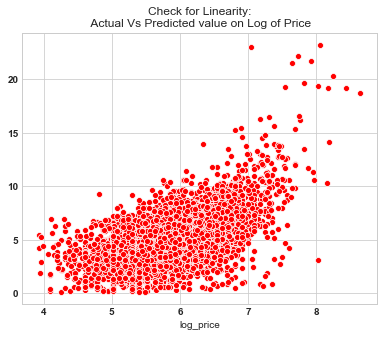

In [22]:
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y,y_pred,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value on Log of Price')

Text(0.5, 1.0, 'Check for Linearity:\n Actual Vs Predicted value on Original Price')

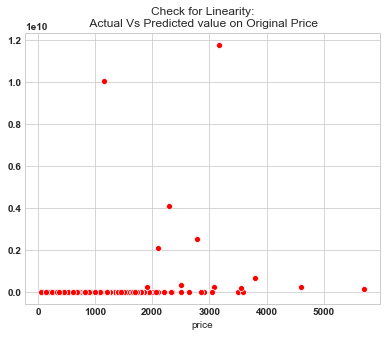

In [21]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_actual,y_pred_level,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value on Original Price')

From the plots above, we can see that the model overall underpredicts a lot on the original price. It shows significant nonlinearity. Check the linearity between price and input variables below:

Text(0.5, 1.0, 'Check for Linearity:\n para1 Vs price')

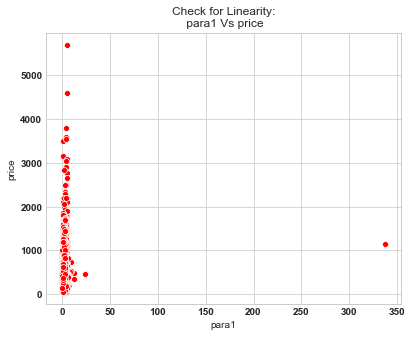

In [25]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(df_encode['para1'],df_encode['price'],ax=ax,color='r')
ax.set_title('Check for Linearity:\n para1 Vs price')

Text(0.5, 1.0, 'Check for Linearity:\n para2 Vs price')

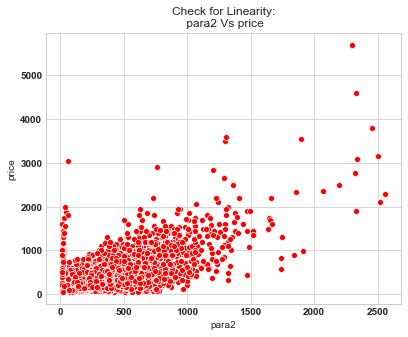

In [26]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(df_encode['para2'],df_encode['price'],ax=ax,color='r')
ax.set_title('Check for Linearity:\n para2 Vs price')

Text(0.5, 1.0, 'Check for Linearity:\n para4 Vs price')

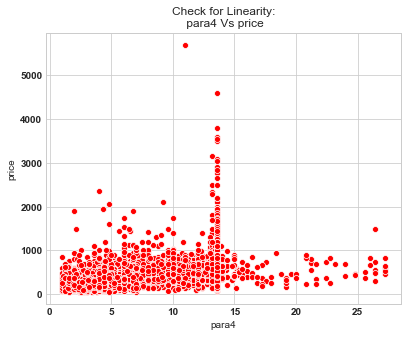

In [27]:
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(df_encode['para4'],df_encode['price'],ax=ax,color='r')
ax.set_title('Check for Linearity:\n para4 Vs price')

From the plots above, we can see that the relationship between price and the numeric variables is nonlinear, and therefore regression tree method is considered. Given that para 3 and 4 have higher correlation, para 3 is not checked for linearity.